# TP CUDA - October 2022

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

## Part 1 : Pi

### Compilation and performance evaluation

In [34]:
!make pi

In [8]:
df_pi_1_thread = pd.read_csv("pi.csv")
df_pi_mt = pd.read_csv("pi_mt.csv")
df_pi_atomic = pd.read_csv("pi_atomic.csv")
df_pi_msr = pd.read_csv("pi_msr.csv")

df_pi_1_thread["method"] = "1_thread"
df_pi_mt["method"] = "n_threads"
df_pi_atomic["method"] = "atomic"
df_pi_msr["method"] = "reduction"

df_pi = pd.concat([df_pi_1_thread, df_pi_mt, df_pi_atomic, df_pi_msr])

### Performance analysis

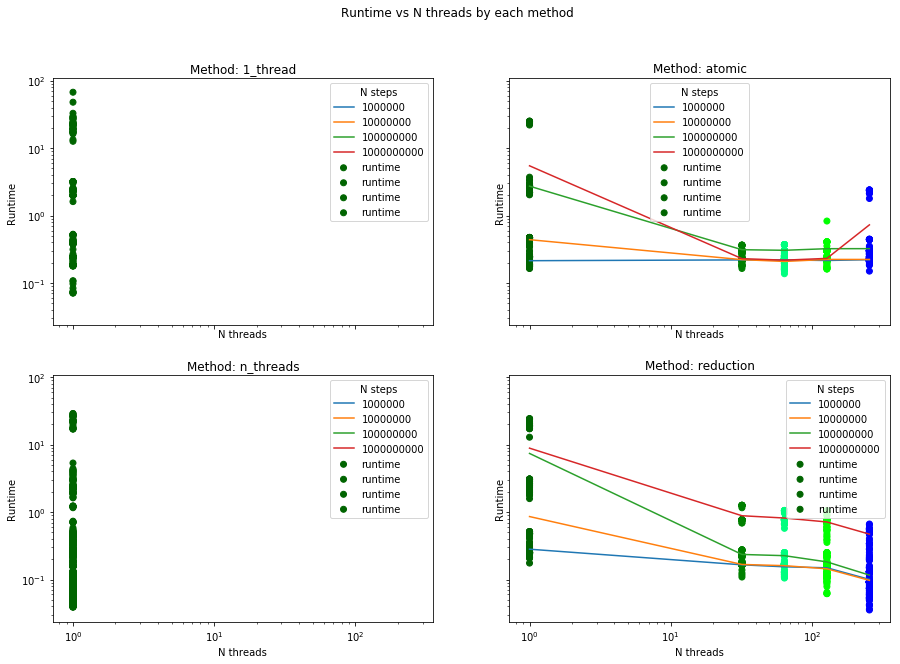

In [13]:
color_num_steps = {1 : "darkgreen", 32 : "green", 64 : "springgreen", 128 : "lime", 256: "blue"}
ax_methods = { "1_thread": [0,0], "n_threads": [1, 0], "atomic": [0, 1], "reduction": [1, 1]}

x = 'num_steps'
y = 'runtime'

fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)

for x_value in df_pi[x].unique():
    for method in df_pi['method'].unique(): 
        ax_x, ax_y = ax_methods[method];
        ax = axs[ax_x, ax_y]

        df_x_value = df_pi[(df_pi[x] == int(x_value))]
        df_plot = df_x_value[df_x_value['method'] == method]
        
        mean_stats = df_plot.groupby([x,'method', 'num_threads']).mean().reset_index()
        
        ax.plot(mean_stats['num_threads'], mean_stats[y], linestyle="solid", label=x_value)
        sct = ax.scatter(df_plot['num_threads'], df_plot[y], c=df_plot['num_threads'].apply(lambda n : color_num_steps[n]))
        ax.set_xlabel("N threads")
        ax.set_ylabel("Runtime")
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title("Method: " + method)
        ax.legend(title="N steps")
    
fig.suptitle('Runtime vs N threads by each method', fontsize='large')
plt.show()

In the previous diagrams, we can see the comparaison between the 4 methods according the number of threads used vs the runtime. Something interesting to notice is that the runtime of the first two methods is always increasing while adding more threads. However, the runtime of the last two (reduce and split) is reducing as the number of threads increase. This is due to the last two methods create multiple tasks that can be done by different threads in parallel. On the other side, the first two methods block a part of the memory (atomic) or the execution (critical) and generate a bottleneck where the threads have to wait to continue doing their work. 

We can also see that the run times of different number of steps come closer as the number of threads increase for the last two methods. This is due to the fact that the more threads we have, the more tasks we can create and the more work we can do in parallel.

Last but not least, we can see that the run times of each repetition are more spread on critical and atomic, in other words, it is more difficult to determine what is going to be the final runtime. This differs from the last two methods that doesn't have too much spreads on the samples and the final runtime is more predictable.

Text(0.5, 0.98, 'Runtime Analysis of each method by N steps')

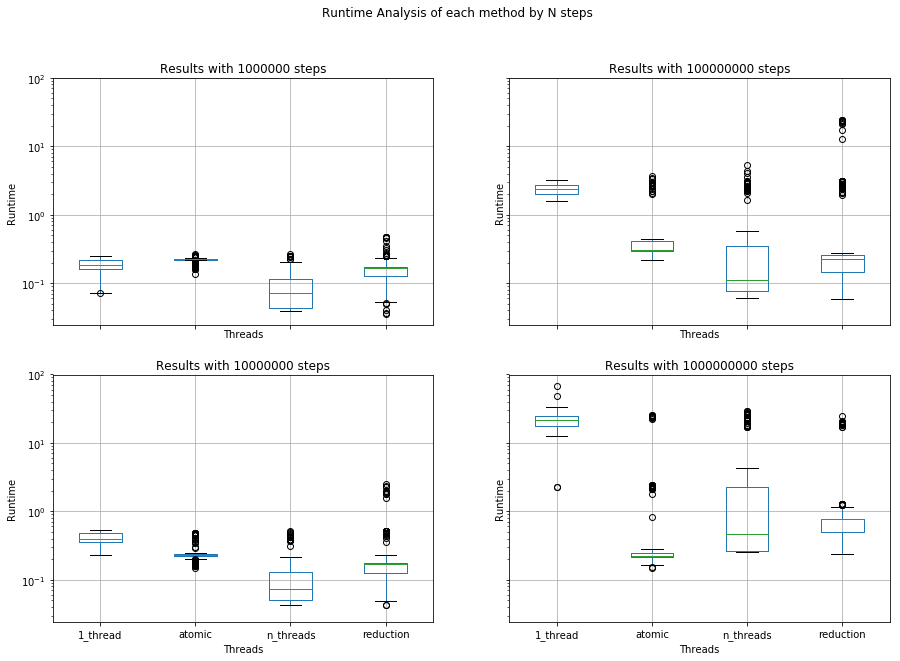

In [17]:
ax_num_steps = { 1000000: [0,0], 10000000: [1, 0], 100000000: [0, 1], 1000000000: [1, 1]}

fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)

for x_value in df_pi['num_steps'].unique():
  ax_x, ax_y = ax_num_steps[x_value];
  ax = axs[ax_x, ax_y]

  df_x_value = df_pi[(df_pi['num_steps'] == int(x_value))]
  df_threads = df_x_value.pivot(columns='method', values='runtime')
  df_threads.boxplot(ax=ax)
  plt.yscale('log')
  ax.set_title('Results with ' + str(x_value) + ' steps')
  ax.set_xlabel('Method')
  ax.set_ylabel('Runtime')

fig.suptitle('Runtime Analysis of each method by N steps', fontsize='large')

In the latest diagram, we have the general results of all executions, all the number of threads and steps with a repetition of 10 times by each execution. They are divided by method and by N steps.

We can look that the critical method is the worst between all the methods. With a mean between `E-2` and `E-1`. This result shows that the **critical sections** in competing software must be thought of with calm because they can cause all the software to lose performance. By the contrary, methods without critical sections are faster due to the threads doesn't have to wait in queue for each other to finish doing what they are doing. In this case reduction and split (which uses reduce under the hood) are faster with a mean around `E-3`. We can look that even in the worst reduction execution or split, it is faster than the critical mean. Also, we can look that even if the split's mean says that split is faster than reduction, the standard deviation is almost the same, or in other words, the best reduction case is almost the same as the best of split.

As conclusion, we can say that for similar problems is better use reduction, but it is important to visualize that it uses more memory in the machine. So if the data allows it, we can use reduction and only if the difference is really large, we can use split. The split method is not the best in all cases, because it makes more complex the code, but it can be efficient in the case that you really have a lot of data and not enough memory.

## Part 2 : Vector

### Compilation and performance evaluation

In [ ]:
!make vector
!make vector_omp
!make vector_simd

### Performance analysis

In [12]:
df_vector = pd.read_csv("vector.csv")
df_omp = pd.read_csv("vector_omp.csv")
df_simd = pd.read_csv("vector_simd.csv")


df_vector["method"] = "vector"
df_omp["method"] = "vector_omp"
df_simd["method"] = "vector_simd"

df_vector_methods = pd.concat([df_vector, df_omp, df_simd])

df_vector_methods["S"] = df_vector_methods["N"] * df_vector_methods["M"]

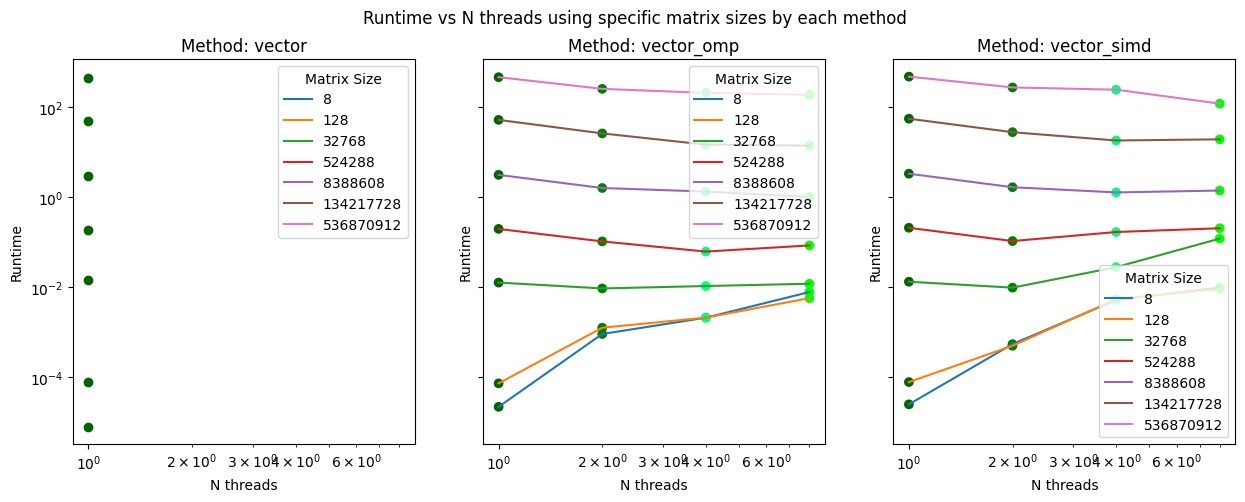

In [62]:
color_num_threads = {1 : "darkgreen", 2 : "green", 4 : "springgreen", 8 : "lime"}
ax_methods = { "vector": [0,0], "vector_omp": [1, 0], "vector_simd": [2, 0]}

x = 'S'
y = 'time'

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

for x_value in df_vector_methods[x].unique():
    for method in df_vector_methods['method'].unique(): 
        ax_x, ax_y = ax_methods[method];
        ax = axs[ax_x]

        df_x_value = df_vector_methods[(df_vector_methods[x] == int(x_value))]
        df_plot = df_x_value[df_x_value['method'] == method]
        
        mean_stats = df_plot.groupby([x,'method', 'num_threads']).mean().reset_index()
        
        ax.plot(mean_stats['num_threads'], mean_stats[y], linestyle="solid", label=x_value)
        sct = ax.scatter(df_plot['num_threads'], df_plot[y], c=df_plot['num_threads'].apply(lambda n : color_num_threads[n]))
        ax.set_xlabel("N threads")
        ax.set_ylabel("Runtime")
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title("Method: " + method)
        ax.legend(title="Matrix Size")
    
fig.suptitle('Runtime vs N threads using specific matrix sizes by each method', fontsize='large')
plt.show()

In the previous diagram we can see the comparaison between the 3 methods according the number of threads used vs the runtime. The first method doesn't use OMP or SIMD, so it is done sequential, this mean that it is only executed in one thread. 

The other two methods are executed using OMP and OMP+SIMD. The second one uses OMP on the first iteration (rows) and sequential in the second one (columns) and the third one uses OMP on the first iteration (rows) and SIMD in the second one (columns).

We can see that the performance in one thread is the same for the all the methods due to they are the same. However, when we add more threads, the concurrent methods are increasing the runtime (going slower) for small matrix sizes but reducing the runtime (going faster) for higher matrix sizes. This is due to the fact that dividing the work is also a work that have to be done, this add extra time to the execution. Therefore, for small sizes it is better to do it sequentially, but for higher sizes it is better to divide the work and do it in parallel as we can see in the diagrams.

We can see that if we count with a sufficient amount of thread and a substantial matrix size we should opt for OMP+SIMD. If we don't have a lot of threads but the matrix size is still big, we should opt for only OMP and if the matrix size is small we should opt for sequential. 

Text(0.5, 1.0, 'Runtime Analysis of each method by matrix size')

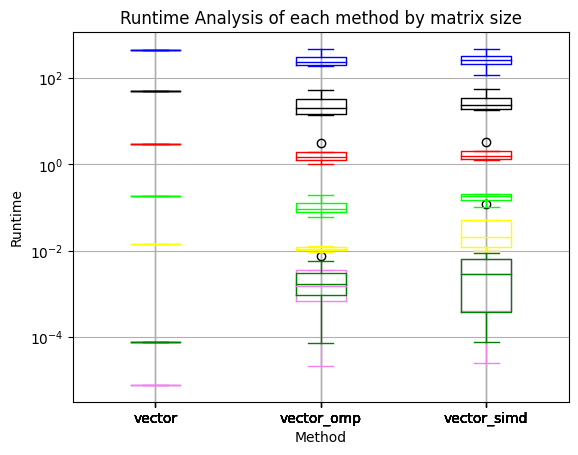

In [61]:
color_s = {8 : "violet", 128 : "green", 32768 : "yellow", 524288 : "lime", 8388608: "red", 134217728: "black", 536870912: "blue"}

x = 'S'

for x_value in df_vector_methods[x].unique():
  df_x_value = df_vector_methods[(df_vector_methods[x] == int(x_value))]
  df_threads = df_x_value.pivot(columns='method', values='time')
  df_threads.boxplot(color=color_s[x_value])

plt.yscale('log')
plt.xlabel('Method')
plt.ylabel('Runtime')
plt.title('Runtime Analysis of each method by matrix size', fontsize='large')

In the latest diagram, we have the general results of all executions, all the number of threads and matrix sizes. The idea is to visualize the mean, medium and standard deviation of each method for each matrix size. Each color is a different matrix size. More in the top, bigger the matrix size. 

We can compare the last two methods against the first one and see that the mean is increasing for the same small matrix size while using the parallel methods. This is due to the fact that the parallel methods are adding extra time to the execution while dividing the tasks between threads. However, for bigger matrix sizes, the mean is decreasing for the parallel methods. This is due to the fact that the parallel methods are efficiently dividing the tasks. We can see that the standard deviation is higher while using OMP+SIMD. This is due to the fact that the SIMD method is more complex and it is more difficult to divide the tasks between threads. This means that we're adding extra complexity to the system and we should plan it carefully.